First we import the library, forcing reload from local version (not pip install). 

In [1]:
import os
import sys
import importlib
import matplotlib.pyplot as plt


# Get the absolute path to the directory containing the local module
stlrom_path = os.path.abspath('../build')
print(stlrom_path)

# Insert the local module path at the beginning of sys.path
sys.path.insert(0, stlrom_path)

import stlrom

# Reload the module to ensure it is loaded from the new path
importlib.reload(stlrom)

import stlrom as sr
import numpy as np


/home/alex/Dropbox/workspace/decyphir/Det-ai/STLRom/build


# Signals


## Function


In [ ]:
import matplotlib.pyplot as plt

# Plotting
def plot_signal(signal,label=None, fig=None):
    samples_list = signal.get_samples_list()

    if fig is None:
        fig = plt.figure(figsize=(15, 5)).gca()

    if label is None:
        label = f'Signal {len(fig.get_lines()) + 1}'

    fig.set_xlabel('Time')
    fig.set_ylabel('Value')
    fig.set_title('Signal Plot')
    fig.grid(True)
        

    def plot_sample(s, dt, color=None):
        if color is None:
            l, = fig.plot(s.time, s.value, marker='o')
            color = l.get_color()
            l = fig.plot([s.time, s.time+dt], [s.value, s.value_at(s.time+dt)], color=color, linestyle='-')
        else:
            l = fig.plot(s.time, s.value, marker='o', color=color)
            l = fig.plot([s.time, s.time+dt], [s.value, s.value_at(s.time+dt)], color=color, linestyle='-')
        return color,l
    
    
    s = samples_list[0]
    sn = samples_list[1]
    dt = sn.time-s.time
        
    col,l = plot_sample(s, dt)
    l[0].set_label(label)
    
    for i in range(1, len(samples_list)-1):
        s = samples_list[i]
        sn = samples_list[i+1]
        dt = sn.time-s.time
        plot_sample(s,dt,color=col)
    
    plot_sample(sn, signal.end_time-sn.time, col)
    #fig.plot(sn.time, sn.value, marker='o', color=col)
    fig.legend()
    fig.figure.canvas.draw()

    return fig

# Printing
def print_signal(signal):
    for s in signal.get_samples_list():
        s.print_sample()
    print('begin_time ', signal.begin_time)
    print('end_time    ',signal.end_time)



## Test signals

### Basic test signals

In [3]:
# One sample
sig0 = sr.Signal()
sig0.append_sample(0, -1)
sig0.append_sample(1., 1)

sig1 = sr.Signal()
sig1.append_sample(.3, 2)
sig1.append_sample(.6, 1.5)
sig1.append_sample(1.3, -3)

sig2 = sr.Signal()



In [4]:
sig = sig1

sig_bool = sr.Signal()
sig_bool.compute_boolean(sig)
sig_ltr = sr.Signal()
sig_ltr.compute_left_time_rob(sig)
sig_rtr = sr.Signal()
sig_rtr.compute_right_time_rob(sig)


In [5]:
print_signal(sig_ltr)
print_signal(sig_bool)

begin_time  0.3
end_time     1.3
begin_time  0.3
end_time     1.3
Time 0.30000 Value 0.00000 Derivative 1.00000
Time 0.83333 Value -0.00000 Derivative -1.00000
Time 0.30000 Value 1.00000 Derivative 0.00000
Time 0.83333 Value 0.00000 Derivative 0.00000


<Axes: title={'center': 'Signal Plot'}, xlabel='Time', ylabel='Value'>

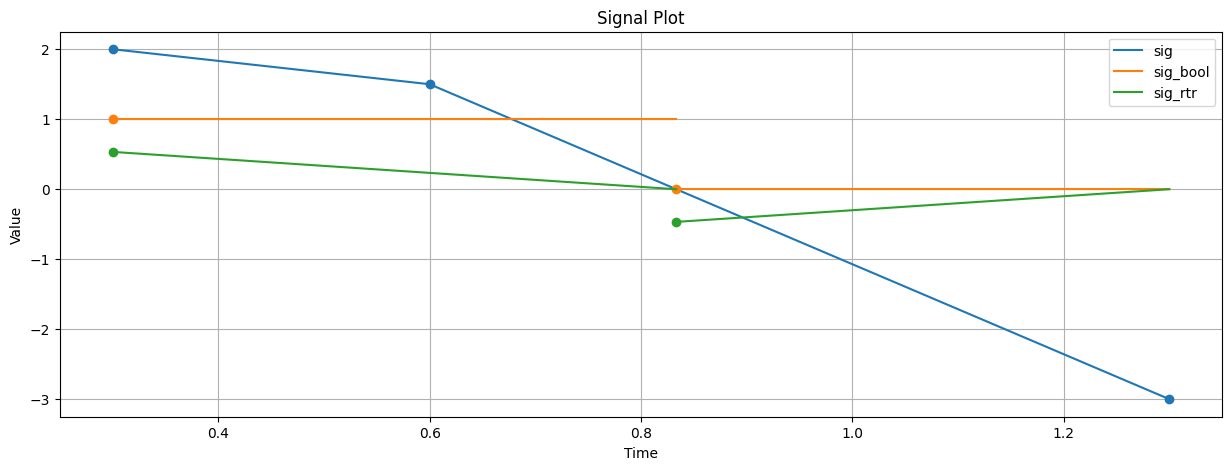

In [ ]:
fig = plot_signal(sig, label='sig')
plot_signal(sig_bool, label='sig_bool', fig=fig)
#plot_signal(sig_ltr, label='sig_ltr', fig=fig)
plot_signal(sig_rtr, label='sig_rtr', fig=fig)

### Longer signals

<Axes: title={'center': 'Signal Plot'}, xlabel='Time', ylabel='Value'>

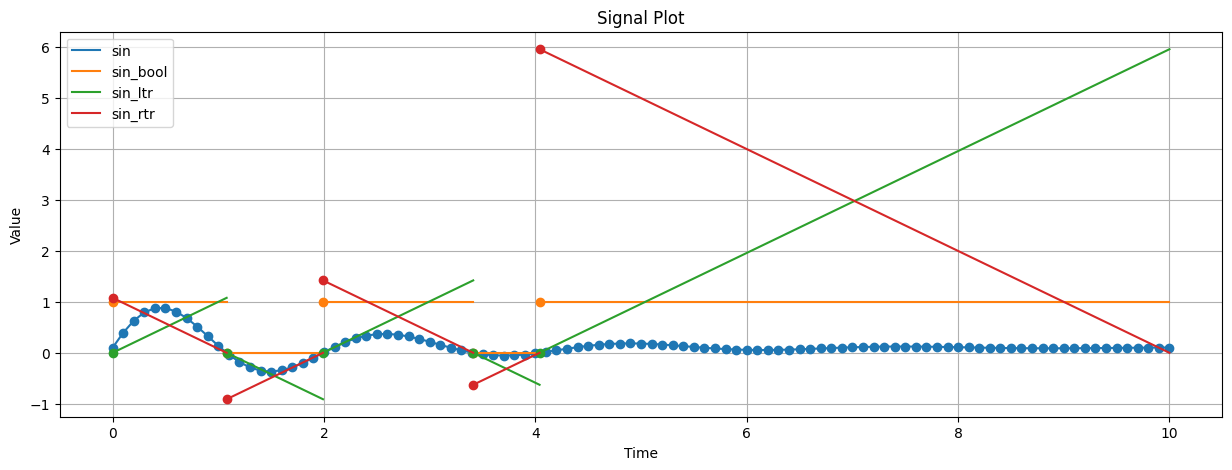

In [ ]:
times = np.arange(0, 10.1, .1)
sin_val = np.sin(times*np.pi/2)
overshoot_val = np.sin(times*np.pi*np.exp(-times/50))*np.exp(-times/2)+.1
sig_sin = sr.Signal()
sig_overshoot = sr.Signal()

for i in range(0,len(times)):
    sig_sin.append_sample(times[i],sin_val[i])
    sig_overshoot.append_sample(times[i],overshoot_val[i])

sig_sin_bool= sr.Signal()
sig_sin_ltr = sr.Signal()
sig_sin_rtr = sr.Signal()

sig = sig_overshoot
sig_sin_bool.compute_boolean(sig)
sig_sin_ltr.compute_left_time_rob(sig)
sig_sin_rtr.compute_right_time_rob(sig)
fig = plot_signal(sig, label='sin')
plot_signal(sig_sin_bool, label='sin_bool', fig=fig)
plot_signal(sig_sin_ltr, label= 'sin_ltr', fig=fig)
plot_signal(sig_sin_rtr, label= 'sin_rtr', fig=fig)



In [ ]:
for s in sig_sin_bool.get_samples_list():
    s.print_sample()


# Drivers

We instantiate an STLDriver object. This object is essentially a parser to create and store STL formulas.  

In [9]:
stl_parser = stlrom.STLDriver()

We need to declare signals, parameters (optional), and formulas. For this we can use the `parse_string()` method. 

In [10]:
stl_parser.parse_string("signal x, y")       # declaring signals named 'x' and 'y'
stl_parser.parse_string("param p=0.2, tau=5") # declaring parameters named 'p' and 'q'
# Let's add some formulas
stl_parser.parse_string("mu_x := x[t] > 0 ") # a atomic proposition
stl_parser.parse_string("mu_y := y[t] < p ") # another atomic proposition
stl_parser.parse_string("mu := mu_x and mu_y") # a compound proposition
stl_parser.parse_string("phi := ev_[0, tau] mu") # a temporal proposition

True

The STLDriver object can create STLMonitor objects, which are used to evaluate properties on data. 

In [18]:
mu_x = stl_parser.get_monitor("mu_x")

def add_signals(mon,times, sig_x, sig_y):
    for i in range(0, len(times)):
        mon.add_sample([times[i],sig_x[i],sig_y[i]])
    return mon

mu_x = add_signals(mu_x, times, sin_val, overshoot_val)



We are now ready to evaluate formulas. For this we use the get_online_rob() method. 

In [ ]:
mu_x.set_eval_time(0, 5)
mu_x.eval_robustness()

0.0

In [24]:
z = mu_x.get_signal()

In [25]:
print_signal(z)

begin_time  0.0
end_time     5.0
Time 0.00000 Value 0.00000 Derivative 1.56434
Time 0.10000 Value 0.15643 Derivative 1.52583
Time 0.20000 Value 0.30902 Derivative 1.44974
Time 0.30000 Value 0.45399 Derivative 1.33795
Time 0.40000 Value 0.58779 Derivative 1.19322
Time 0.50000 Value 0.70711 Derivative 1.01910
Time 0.60000 Value 0.80902 Derivative 0.81990
Time 0.70000 Value 0.89101 Derivative 0.60050
Time 0.80000 Value 0.95106 Derivative 0.36632
Time 0.90000 Value 0.98769 Derivative 0.12312
Time 1.00000 Value 1.00000 Derivative -0.12312
Time 1.10000 Value 0.98769 Derivative -0.36632
Time 1.20000 Value 0.95106 Derivative -0.60050
Time 1.30000 Value 0.89101 Derivative -0.81990
Time 1.40000 Value 0.80902 Derivative -1.01910
Time 1.50000 Value 0.70711 Derivative -1.19322
Time 1.60000 Value 0.58779 Derivative -1.33795
Time 1.70000 Value 0.45399 Derivative -1.44974
Time 1.80000 Value 0.30902 Derivative -1.52583
Time 1.90000 Value 0.15643 Derivative -1.56434
Time 2.00000 Value 0.00000 Derivative

In [ ]:
plot_samples(z)

0

In [19]:
monitor.eval_robustness()

2.0